<a href="https://colab.research.google.com/github/Chri1629/dsim_project/blob/main/audio/audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Progetto di Digital Signal & Image Management**

## Parte 1 - Audio recognition


*2020/21*

Peracchi Marco 800578

Uccheddu Christian 800428

# Abstract

Questa sezione del progetto si occupa di identificare da una traccia audio di una persona se quest'ultima stia effettivamente leggendo un testo oppure no, cercando di comprendere tonalità improvvisate rispetto a quelle di una lettura. In particolare sono state utilizzare due tecniche:

- **SVM**: Sulle tracce audio viene applicata una Support Vector Machine e successivamente vengono analizzati i risultati in un classification report e una matrice di confusione.

- **Spettrogrammi di MEL**: dalle tracce audio vengono generati gli spettrogrammi di MEL, immagini che vengono utilizzate per addestrare delle reti neurali. In particolare si usano una rete pretrainata tagliata e a cui è stato aggiunto un classificatore logistico, una rete pretrainata a cui viene aggiunto un layer denso e una rete CNN costruita da 0.

Vengono importate le librerie necessarie.

In [1]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav
import IPython.display as ipd
import librosa
import re
import seaborn as sns

import matplotlib.pyplot as plt

import pandas as pd

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

import librosa.display
from sklearn.preprocessing import scale

import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import mobilenet

Si utilizza Drive per importare i dati e viene salvata la directory per questioni di comodità.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

base_dir = "gdrive/MyDrive/DigitalSignal/corretti/"

Mounted at /content/gdrive


# Modello SVM

Il primo modello definito è la Support Vector Machine.

## Feature Extractor

Vengono definite una serie di funzioni che verranno utilizzate come *feature extractor* da aggiungere alla traccia audio. Visto la tipologia del problema ci si aspetta che la funzione più utile possa essere la **zero crossing rate**, in quanto un testo improvvisato dovrebbe contenere più momenti di silenzio rispetto a un testo letto.

In [ ]:
def combo(input):
    return np.concatenate((aavg(input), duration(input), zcr(input), sdev(input)))

In [ ]:
def zcr(input, n_shift = 1):    
    # Remove all 0's as said before
    input = [x for x in input if x != 0]
    # It adds a number of 0 to the end equal to the n_shifts and deletes the first n_shift elements
    shifted = np.concatenate((input, np.zeros(n_shift)))[n_shift:]
    # If the signs agree and at least one of the two is 0, the value 0 is inserted, if the signs are discordant, the value 1 is inserted
    r = np.where((np.sign(shifted) * np.sign(input) >= 0),
                       0, 1)
    # Counts the number of 1's
    return np.sum(r[:-1], keepdims = True)

In [ ]:
def duration(input):
    return input.shape

In [ ]:
def aavg(input):
    return np.mean(np.abs(input), keepdims=True)

In [ ]:
def sdev(input):
    return np.std(input, keepdims = True)

In [ ]:
def crop(input, size =100):
    output = input[0:min(size, input.shape[0])]        
    # Aggiungo tanti zeri quanti ne passano tra la differenza tra la dimensione voluta e quella effettiva del file
    output = np.concatenate((output, np.zeros(size - output.shape[0])))        
    return output

## Data loader

La funzione **data loader** ci permette di importare i dati già suddivisi in cartelle ed assegnargli l'etichetta corretta. Inoltre, divide già i dati in train e validation. Opzionalmente è possibile normalizzare i dati oppure definire *feature extractor* permettendo di aggiungere features in coda alle tracce audio. La seguente funzione *load_data* esegue quanto appena descritto.

In [ ]:
def identity(input):
    return input

def load_data(feature_extractor=identity, normalize=False):
    # Inizializzazione
    labels = []
    features = []
    
    # Ciclo for su ogni file presente nella directory
    for f in sorted(os.listdir(base_dir)):

        # Controllo sull'estensione del file
        if f.endswith('.mp3'):

            # Lettura della traccia e della frequenza di campionamento, la traccia viene tagliata a 7 secondi massimo.
            signal, sr = librosa.load(base_dir + f, duration= 7.0, sr=None)
            # Estrazione delle feature se la funzione è stata definita
            cur_features = feature_extractor(signal)
            features.append(cur_features)
            print(f)
            # Lettura e acquisizione della classe di appartenenza
            label = re.search(r'^(\d+)_([01])\.mp3$', f).group(2)
            labels.append(label)

    # Divisione del dataset in train e validation
    X_train, X_validation, y_train, y_validation = train_test_split(features, labels, test_size=0.3, random_state=1)

    # Normalizzazione dei dati se specificato
    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_validation = [row for row in (np.array(X_validation) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_validation, y_train, y_validation

In [ ]:
X_train, X_validation, y_train, y_validation = load_data(feature_extractor=combo, normalize = True)

001_1.mp3
002_1.mp3
003_1.mp3
004_1.mp3
005_1.mp3
006_1.mp3
007_1.mp3
008_1.mp3
009_1.mp3
010_1.mp3
011_1.mp3
012_1.mp3
013_1.mp3
014_1.mp3
015_1.mp3
016_1.mp3
017_1.mp3
018_1.mp3
019_1.mp3
020_1.mp3
021_1.mp3
022_1.mp3
023_1.mp3
024_1.mp3
025_1.mp3
555_0.mp3
556_0.mp3
557_0.mp3
558_0.mp3
559_0.mp3
560_0.mp3
561_0.mp3
562_0.mp3
563_0.mp3
564_0.mp3
565_0.mp3
566_0.mp3
567_0.mp3
568_0.mp3
569_0.mp3
570_0.mp3
571_0.mp3
572_0.mp3
573_0.mp3
574_0.mp3
575_0.mp3
576_0.mp3
577_0.mp3
578_0.mp3
579_0.mp3


## Addestramento

Viene utilizzato un kernel di tipo *Gaussiano* in modo da rendere più flessibile l'iperpiano che separa i dati.

In [ ]:
clf = SVC(kernel ='rbf', class_weight='balanced')
clf = clf.fit(X_train, y_train) # Fit dei dati
y_pred = clf.predict(X_validation) # Previsioni sul validation set

In [ ]:
print(classification_report(y_validation, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.80      1.00      0.89         4

    accuracy                           0.93        15
   macro avg       0.90      0.95      0.92        15
weighted avg       0.95      0.93      0.94        15



In [ ]:
cm = confusion_matrix(y_validation, y_pred)

fig = plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, annot_kws={"size": 16},
           linewidths=.1, cmap="YlGnBu")
plt.xlabel("True Class", size = 15)
plt.ylabel("Predicted Class", size = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
ax.yaxis.set_ticklabels(['Letto', 'Improvvisato']) 
ax.xaxis.set_ticklabels(['Letto', 'Improvvisato']) 

plt.title("Confusion matrix", size = 20)

NameError: ignored

Dai risultati del classification report si può notare che le performance sono discrete ma sicuramente migliorabili. Dalla confusion matrix si nota invece che molti audio **improvvisati** vengono classificati come **letti**; questo è un risultato che ci si poteva aspettare in quanto è facile che si possa rispondere ad una domanda con prontezza in modo da sembrare che sia letta.

# CNN 2D

Si passa ora agli spettrogrammi di Mel e alla definizione delle reti neurali.

## Spettrogrammi

La funzione seguente *create_spect* analizza ciascun audio presente nella directory fornita e ne crea il corrispettivo spettrogramma di Mel.

In [ ]:
def create_spect():

  # Ciclo for su ogni file presente nella directory
  for f in sorted(os.listdir(base_dir)):
    # Controllo sull'estensione del file
    if f.endswith('.mp3'):
            # Lettura della traccia e della frequenza di campionamento, la traccia viene tagliata a 7 secondi massimo.
            signal, sr = librosa.load(base_dir + f, duration= 7.0, sr=None)
            # Estrazione del nome del file
            name = re.search(r'^(\d+)_([01])\.mp3$', f).group(1)
            # Estrazione della classe di appartenenza
            label = re.search(r'^(\d+)_([01])\.mp3$', f).group(2)
            # Creazione dello spettrogramma
            spect = librosa.feature.melspectrogram(y=signal, n_mels=128)
            fig = plt.figure(figsize=(4,4))
            ax = fig.add_subplot(111)
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            ax.set_frame_on(False)
            # Conversione da ampiezze a decibel
            S_dB = librosa.power_to_db(spect, ref=np.max)
            # Salvataggio dell'immagine
            img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', ax=ax)
            # L'immagine viene salvata con la label corretta nel nome
            if int(label) == 0:
              fig.savefig("gdrive/MyDrive/spectrograms/letto/{}_{}.png".format(name, label), dpi = 100)
            else:
              fig.savefig("gdrive/MyDrive/spectrograms/improvvisato/{}_{}.png".format(name, label), dpi = 100)
            plt.close("all")

In [ ]:
create_spect()

001_1.mp3
002_1.mp3
003_1.mp3
004_1.mp3
005_1.mp3
006_1.mp3
007_1.mp3
008_1.mp3
009_1.mp3
010_1.mp3
011_1.mp3
012_1.mp3
013_1.mp3
014_1.mp3
015_1.mp3
016_1.mp3
017_1.mp3
018_1.mp3
019_1.mp3
020_1.mp3
021_1.mp3
022_1.mp3
023_1.mp3
024_1.mp3
025_1.mp3
026_1.mp3
027_1.mp3
028_1.mp3
029_1.mp3
030_1.mp3
031_1.mp3
032_1.mp3
033_1.mp3
034_1.mp3
035_1.mp3
036_1.mp3
037_1.mp3
038_1.mp3
039_1.mp3
040_1.mp3
041_1.mp3
042_1.mp3
043_1.mp3
044_1.mp3
045_1.mp3
046_1.mp3
047_1.mp3
048_1.mp3
049_1.mp3
050_1.mp3
051_1.mp3
052_1.mp3
053_1.mp3
054_1.mp3
055_1.mp3
056_1.mp3
057_1.mp3
058_1.mp3
059_1.mp3
060_1.mp3
061_1.mp3
062_1.mp3
063_1.mp3
064_1.mp3
065_1.mp3
066_1.mp3
067_1.mp3
068_1.mp3
069_1.mp3
070_1.mp3
071_1.mp3
072_1.mp3
073_1.mp3
074_1.mp3
075_1.mp3
076_1.mp3
077_1.mp3
078_1.mp3
079_1.mp3
080_1.mp3
081_1.mp3
082_1.mp3
083_1.mp3
084_1.mp3
085_1.mp3
086_1.mp3
087_1.mp3
088_1.mp3
089_1.mp3
090_1.mp3
091_1.mp3
092_1.mp3
093_1.mp3
094_1.mp3
095_1.mp3
096_1.mp3
097_1.mp3
098_1.mp3
099_1.mp3
100_0.mp3


## Split train - validation - test

Si utilizza ora la libreria **splitfolders**, la quale ci permette comodamente di dividere il dataset in train, validation e test, creando le rispettive cartelle. in tal modo sarà possibile utilizzare i generator di Keras.

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio("gdrive/MyDrive/spectrograms", output="gdrive/MyDrive/spectrograms_model", ratio=(0.6, 0.3, 0.1))

Copying files: 800 files [00:10, 73.44 files/s]


## Generator

Vengono ora definiti i differenti **generator** per il train, validation e test set. Nella definizione dei generatori vengonon utilizzate le stesse operazioni di preprocessing della **mobilenet**, ossia la rete neurale che useremo. Inoltre viene utilizzata come **batch size** la stessa dimensione dei dati, in modo da poter definire i vettori *x* e *y*. Questa operazione è necessaria in quanto la rete che addestreremo verrà tagliata prima della fine per ottenere features più generali, e i vettori dovranno essere cambiati successivamente di dimensione.

In [ ]:
train_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = mobilenet.preprocess_input)

train_generator = train_processing.flow_from_directory("gdrive/MyDrive/DigitalSignal/spectrograms_model/train",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 640,
                                    class_mode = "categorical",
                                    shuffle = False,
                                    seed = 1 )

x_train, y_train = next(train_generator)

Found 640 images belonging to 2 classes.


In [ ]:
validation_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function= mobilenet.preprocess_input)

validation_generator = validation_processing.flow_from_directory("gdrive/MyDrive/DigitalSignal/spectrograms_model/val",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 240,
                                    class_mode = "categorical",
                                    shuffle = False,
                                    seed = 1)

x_validation, y_validation = next(validation_generator)

Found 240 images belonging to 2 classes.


In [ ]:
test_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function= mobilenet.preprocess_input)

test_generator = test_processing.flow_from_directory("gdrive/MyDrive/DigitalSignal/spectrograms_model/test",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 80,
                                    class_mode = "categorical",
                                    shuffle = False,
                                    seed = 1)

x_test, y_test = next(test_generator)

Found 80 images belonging to 2 classes.


## MobileNet tagliata

Viene utilizzata la rete **MobileNet** in quanto presenta un numero non troppo elevato di parametri ed è facilmente riaddestrabile. Ovviamente il layer di top non viene incluso.

In [ ]:
base_model = mobilenet.MobileNet(input_shape = (224,224,3),
                        weights = 'imagenet',
                        include_top = False,
                        pooling = 'avg')
base_model.summary()

La rete viene tagliata al layer **conv_dw_10**, in tal modo le features che vengono estratte sono più generali e possono essere usate per la classificazione degli spettrogrammi. Questa operazione è molto importante poiché la rete è inizialmente addestrata su un task completamente diverso (quello di *imagenet*), quindi i pesi dati alle variabili non sarebbero compatibili.


In [ ]:
model_1 = keras.Model(inputs=base_model.input, outputs=base_model.get_layer('conv_dw_10').output)
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

La fase che segue permette di formattare correttamente i dati di train, validation e test, così che possano essere usati dal classificatore classico.

In [ ]:
model_1_features = model_1.predict(x_train)
model_1_features = model_1_features.reshape((model_1_features.shape[0], 
                                             model_1_features.shape[1]*model_1_features.shape[2]*model_1_features.shape[3]))

(640, 14, 14, 512)




Per la tipologia del problema si è deciso di usare un **classificatore logistico**. Questa scelta è dettata da motivazioni empiriche poiché si sono notate le performance migliori.

In [ ]:
lr_1 = LogisticRegression(solver="lbfgs", multi_class="auto", max_iter=30, penalty ='l2', verbose = 1)
lr_1.fit(model_1_features, tf.argmax(y_train, axis=1))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=30,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

In [ ]:
y_pred_train_1 = lr_1.predict(model_1_features)

Si visualizzano i risultati sul train set.

In [ ]:
classification_report_train_1 = classification_report(np.argmax(y_train, axis=1),y_pred_train_1)
print(classification_report_train_1)
classification_report_train_1= classification_report(np.argmax(y_train, axis=1),y_pred_train_1, output_dict=True)
classification_report_train_1 = pd.DataFrame(classification_report_train_1).transpose()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       320
           1       1.00      1.00      1.00       320

    accuracy                           1.00       640
   macro avg       1.00      1.00      1.00       640
weighted avg       1.00      1.00      1.00       640



Ovviamente l'accuratezza sul train set è massima in quanto è l'insieme su cui il classificatore è stato allenato. Si effettuano le stesse procedure per quanto riguarda il validation set

In [ ]:
model_1_validation_features = model_1.predict(x_validation)
model_1_validation_features = model_1_validation_features.reshape(model_1_validation_features.shape[0],
                                                                  model_1_validation_features.shape[1]*model_1_validation_features.shape[2]*model_1_validation_features.shape[3])

In [ ]:
y_pred_validation_1 = lr_1.predict(model_1_validation_features)

In [ ]:
classification_report_validation_1= classification_report(np.argmax(y_validation, axis=1),y_pred_validation_1)
print(classification_report_validation_1)
classification_report_validation_1= classification_report(np.argmax(y_validation, axis=1),y_pred_validation_1, output_dict=True)
classification_report_validation_1 = pd.DataFrame(classification_report_validation_1).transpose()

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       120
           1       0.99      1.00      1.00       120

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



Infine si applica nuovamente il processo al test set.

In [ ]:
model_1_test_features = model_1.predict(x_test)
model_1_test_features = model_1_test_features.reshape(model_1_test_features.shape[0],
                                                      model_1_test_features.shape[1]*model_1_test_features.shape[2]*model_1_test_features.shape[3])

In [ ]:
y_pred_test_1 = lr_1.predict(model_1_test_features)

In [ ]:
classification_report_test_1= classification_report(np.argmax(y_test, axis=1),y_pred_test_1)
print(classification_report_test_1)
classification_report_test_1= classification_report(np.argmax(y_test, axis=1),y_pred_test_1, output_dict=True)
classification_report_test_1 = pd.DataFrame(classification_report_test_1).transpose()

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        40
           1       1.00      0.97      0.99        40

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



Come possiamo notare dal classification report le performance sono davvero ottime per il task. Alla fine del notebook verrà comunque lasciato un esempio di prova per poter vedere in azione la rete.

In [ ]:
model_1.save('gdrive/MyDrive/modello_audio')

## MobileNet intera

Nella seguente sezione la rete, differentemente dalla parte precedente, non viene tagliata, vengono solamente aggiunti i layer finali per ottenere l'output desiderato.

In questo caso i generator sono definiti sempre con le stesse operazioni di preprocessing della mobilenet, tuttavia la *batch size* viene diminuita, in quanto non sarà necessario ottenere i vettori *x* e *y*, e sarà possibile passare al *fit* direttamnte i generator.

In [ ]:
train_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = mobilenet.preprocess_input)

train_generator = train_processing.flow_from_directory("gdrive/MyDrive/DigitalSignal/spectrograms_model/train",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 32,
                                    class_mode = "categorical",
                                    shuffle = False,
                                    seed = 1 )

Found 640 images belonging to 2 classes.


In [ ]:
validation_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function= mobilenet.preprocess_input)

validation_generator = validation_processing.flow_from_directory("gdrive/MyDrive/DigitalSignal/spectrograms_model/val",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 32,
                                    class_mode = "categorical",
                                    shuffle = False,
                                    seed = 1)

Found 240 images belonging to 2 classes.


In [ ]:
test_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function= mobilenet.preprocess_input)

test_generator = test_processing.flow_from_directory("gdrive/MyDrive/DigitalSignal/spectrograms_model/test",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 32,
                                    class_mode = "categorical",
                                    shuffle = False,
                                    seed = 1)

Found 80 images belonging to 2 classes.


Di seguito è possibile verificare che sono stati aggiunti due layer, entrambi **dense**, il primo con funzione di attivazione **RELU** e il secondo con **sigmoid**. Sono state scelte le due funzioni di attivazione poiché considerate adatte al task di classificazione binaria.

In [ ]:
base_net = mobilenet.MobileNet(input_shape = (224,224,3),
                        weights = 'imagenet',
                        include_top = False,
                        pooling = 'avg')

x = base_net.output

x = keras.layers.Dense(64, activation = "relu") (x)
pred = keras.layers.Dense(2, activation = 'sigmoid') (x)

In [ ]:
net2 = keras.Model(inputs = base_net.input, outputs = pred)

In [ ]:
net2.compile(loss = keras.losses.categorical_crossentropy,
           optimizer = keras.optimizers.Adam(),
           metrics = ['accuracy'])

Si procede all'addestramento per un totale di 30 epoche.

In [ ]:
hist2 = net2.fit(train_generator,
       epochs = 30,
       validation_data = validation_generator)

Epoch 1/30
20/20 [==============================] - 6s 307ms/step - loss: 0.4374 - accuracy: 0.8031 - val_loss: 0.7676 - val_accuracy: 0.6375
Epoch 2/30
20/20 [==============================] - 6s 295ms/step - loss: 0.2062 - accuracy: 0.9219 - val_loss: 0.6231 - val_accuracy: 0.6917
Epoch 3/30
20/20 [==============================] - 6s 294ms/step - loss: 0.0825 - accuracy: 0.9859 - val_loss: 0.8171 - val_accuracy: 0.7375
Epoch 4/30
20/20 [==============================] - 6s 294ms/step - loss: 0.0216 - accuracy: 1.0000 - val_loss: 0.6977 - val_accuracy: 0.6917
Epoch 5/30
20/20 [==============================] - 6s 295ms/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 0.6739 - val_accuracy: 0.7042
Epoch 6/30
20/20 [==============================] - 6s 295ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.7203 - val_accuracy: 0.6792
Epoch 7/30
20/20 [==============================] - 6s 307ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.7330 - val_accuracy: 0.7000
Epoch 

Viene definita la funzione *acc_loss* che servirà per visualizzare graficamente i risultati dell'addestramento.

In [ ]:
def acc_loss(history):
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label = "Train loss", color = "red")
    plt.plot(history.history['val_loss'], label="Validation loss", color = "skyblue")
    plt.legend(loc='upper right', fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel('Epochs', size = 15)
    plt.ylabel('Loss', size = 15) 
    
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label = "Train accuracy", color = "red")
    plt.plot(history.history['val_accuracy'], label="Validation accuracy", color = "skyblue")
    plt.legend(loc='upper right', fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel('Epochs', size = 15)
    plt.ylabel('Accuracy', size = 15) 

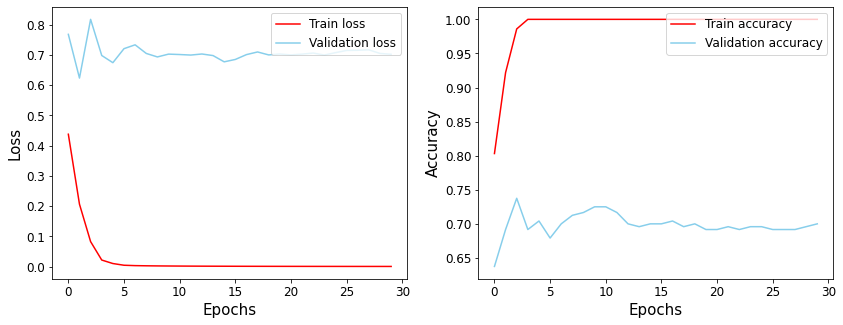

In [ ]:
acc_loss(hist2)

Si valuta la rete sul test set.

In [ ]:
acc2 = net2.evaluate(test_generator)

3/3 [==============================] - 1s 135ms/step - loss: 1.0569 - accuracy: 0.5000


Per meglio comprendere i risultati si procede alla visualizzazione di un classification report e di una matrice di confusione.

In [ ]:
pred_2 = net2.predict(test_generator)

In [ ]:
pred_2 = np.argmax(pred_2, axis = 1)

In [ ]:
print(classification_report(test_generator.classes, pred_2))

              precision    recall  f1-score   support

           0       0.50      0.70      0.58        40
           1       0.50      0.30      0.37        40

    accuracy                           0.50        80
   macro avg       0.50      0.50      0.48        80
weighted avg       0.50      0.50      0.48        80



Text(0.5, 1.0, 'Confusion matrix')

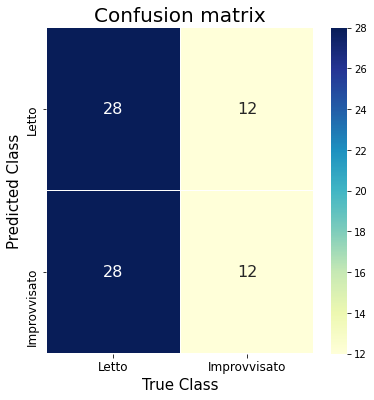

In [ ]:
cm = confusion_matrix(test_generator.classes, pred_2)

fig = plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, annot_kws={"size": 16},
           linewidths=.1, cmap="YlGnBu")
plt.xlabel("True Class", size = 15)
plt.ylabel("Predicted Class", size = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
ax.yaxis.set_ticklabels(['Letto', 'Improvvisato']) 
ax.xaxis.set_ticklabels(['Letto', 'Improvvisato']) 

plt.title("Confusion matrix", size = 20)



Come ci si poteva aspettare, date le considerazioni precedenti, si ha un peggioramento significativo delle performance, poichè le rete mobilenet è pre trainata su un tipo di dataset completamente diverso. L'aggiunta di un ulteriore layer denso complica ancora di più la situazione, rendendo la rete totalmente inutilizzabile per questa tipologia di task.

## CNN

L'ultima rete viene definita direttamente, senza utilizzare altre reti e tecniche di transfer learning. Si considera molto importante provare le performance di una rete più piccola sul nostro problema di classificazione,poiché solitamente le reti pre-addestrate hanno bisogno di insiemi molto più grandi per performare al meglio, che non è il nostro caso.

Viene definita una rete "standard", Costituita da 2 blocchi convoluzionali con relativo Pooling, in cui alla fine è stato attaccato un layer Dense con 128 neuroni. Infine viene attaccato un layer di output con una funzione di attivazione softmax.

In [ ]:
from keras import layers

In [ ]:
model = keras.Sequential(
    [
     keras.Input(shape = (224,224,3)),
     layers.Conv2D(16, kernel_size = (3,3), activation = 'relu'),
     layers.MaxPooling2D(pool_size = (2,2)),
     layers.Conv2D(16, kernel_size = (3,3), activation = 'relu'),
     layers.MaxPooling2D(pool_size = (2,2)),
     layers.Flatten(),
     layers.Dense(128, activation = "relu"),
     layers.Dropout(0.5),
     layers.Dense(2, activation = 'softmax')
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 46656)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 124)               5785468   
_________________________________________________________________
dropout (Dropout)            (None, 124)               0

In [ ]:
model.compile(loss = "categorical_crossentropy",
              optimizer = keras.optimizers.Adam(),
              metrics = ["accuracy"])

histo_best = model.fit(train_generator, 
                       epochs = 30, 
                       batch_size = 128, 
                       validation_data = validation_generator)

Epoch 1/30
1/1 [==============================] - 8s 8s/step - loss: 0.7252 - accuracy: 0.5063 - val_loss: 16.9552 - val_accuracy: 0.5000
Epoch 2/30
1/1 [==============================] - 5s 5s/step - loss: 17.0436 - accuracy: 0.5000 - val_loss: 1.4897 - val_accuracy: 0.5000
Epoch 3/30
1/1 [==============================] - 5s 5s/step - loss: 2.3844 - accuracy: 0.5219 - val_loss: 4.0783 - val_accuracy: 0.5000
Epoch 4/30
1/1 [==============================] - 5s 5s/step - loss: 4.2834 - accuracy: 0.5016 - val_loss: 3.2379 - val_accuracy: 0.5000
Epoch 5/30
1/1 [==============================] - 5s 5s/step - loss: 3.7814 - accuracy: 0.4953 - val_loss: 1.9943 - val_accuracy: 0.5000
Epoch 6/30
1/1 [==============================] - 5s 5s/step - loss: 2.4166 - accuracy: 0.5000 - val_loss: 0.9642 - val_accuracy: 0.5000
Epoch 7/30
1/1 [==============================] - 5s 5s/step - loss: 1.7778 - accuracy: 0.5031 - val_loss: 0.6802 - val_accuracy: 0.5375
Epoch 8/30
1/1 [=======================

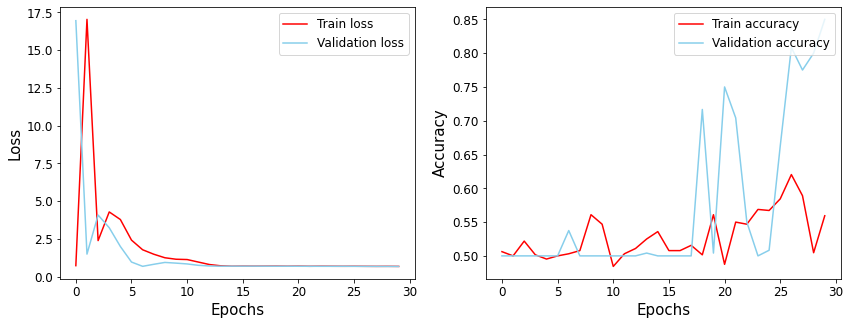

In [ ]:
acc_loss(histo_best)

In [ ]:
acc_best = model.evaluate(test_generator)

1/1 [==============================] - 1s 613ms/step - loss: 0.6736 - accuracy: 0.8375


Le performance sul test set risultano abbastanza buone. Visualizziamo comunque il classification report e la matrice di confusione.

In [ ]:
yc_pred = model.predict(test_generator)
y_pred_best = np.argmax(yc_pred, axis = 1)

In [ ]:
print(classification_report(test_generator.classes, y_pred_best))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84        40
           1       0.85      0.82      0.84        40

    accuracy                           0.84        80
   macro avg       0.84      0.84      0.84        80
weighted avg       0.84      0.84      0.84        80



Come si può notare i valori di f1-score sono molto alti ma comunque inferiori a quelli della MobileNet tagliata.

Text(0.5, 1.0, 'Confusion matrix')

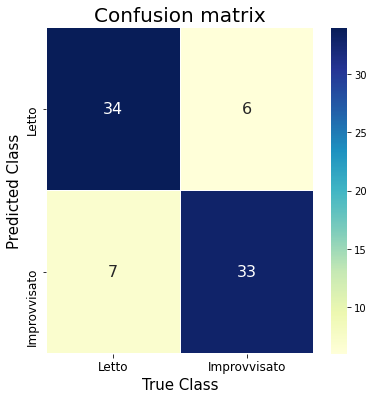

In [ ]:
cm = confusion_matrix(test_generator.classes, y_pred_best)
fig = plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, annot_kws={"size": 16},
           linewidths=.1, cmap="YlGnBu")
plt.xlabel("True Class", size = 15)
plt.ylabel("Predicted Class", size = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
ax.yaxis.set_ticklabels(['Letto', 'Improvvisato']) 
ax.xaxis.set_ticklabels(['Letto', 'Improvvisato']) 

plt.title("Confusion matrix", size = 20)

# Demo

Di seguito proponiamo una demo in cui viene caricato un audio real time e viene eseguita la classificazione da parte del miglior modello trovato in precedenza.

In [5]:
path = "gdrive/MyDrive/DigitalSignal/"
signal, sr = librosa.load(path + "prova7.mp3", duration= 7.0, sr=None) 
ipd.Audio(signal, rate = sr)

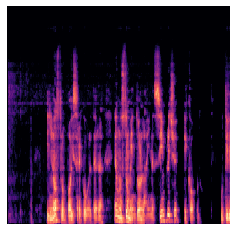

In [6]:
spect = librosa.feature.melspectrogram(y=signal, n_mels=128)
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
S_dB = librosa.power_to_db(spect, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', ax=ax)
fig.savefig(path + "single/test/"+"prova7.png", dpi = 100)

In [7]:
single_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function= mobilenet.preprocess_input)

single_generator = single_processing.flow_from_directory("gdrive/MyDrive/DigitalSignal/single",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 1,
                                    class_mode = "categorical",
                                    shuffle = False,
                                    seed = 1)
test,label_test = next(single_generator)

Found 1 images belonging to 1 classes.


## Predizioni MobileNet tagliata

Di seguito vediamo la predizione della combinazione di MobileNet e classificatore logistico

In [8]:
test_features = model_1.predict(test)
test_features = test_features.reshape(test_features.shape[0],
                                      test_features.shape[1]*test_features.shape[2]*test_features.shape[3])

NameError: ignored

In [ ]:
pred_finali = lr_1.predict(test_features)

In [ ]:
pred_finali

array([0])

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in pred_finali]

predictions

['improvvisato']

## Predizioni CNN

Di seguito vediamo la predizione della rete CNN che è stata costruita da 0.

In [ ]:
prova_pred = model.predict(single_generator)
result = np.argmax(prova_pred, axis = 1)
result

array([1])

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in result]

In [ ]:
predictions

['letto']

In [ ]:
prova_pred

array([[0.49596626, 0.50403374]], dtype=float32)